In [66]:
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
from kneed import KneeLocator
from dython.nominal import associations
from dython.nominal import identify_nominal_columns
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
df_model = pd.read_csv('D:\dwi\pca\dataset\datamaster-edit.csv')
df_model

,Unnamed: 0,code_module,gender,disability,final_result,assessment_type,activity_type,score,total_activities,sum_click,total_interaction
0,0,0,1,0,1,1,16,0.800288,-2.030361,-0.165894,-0.698245
1,1,0,1,0,1,1,16,0.800288,-2.030361,0.572853,-0.698245
2,2,0,1,0,1,1,16,0.800288,-2.030361,-0.561651,-0.698245
3,3,0,1,0,1,1,16,0.800288,-2.030361,-0.535267,-0.698245
4,4,0,1,0,1,1,16,0.800288,-2.030361,-0.403348,-0.698245
...,...,...,...,...,...,...,...,...,...,...,...
1017958,1017958,6,1,0,0,1,5,0.197043,-1.477412,-0.561651,-0.802672
1017959,1017959,6,1,0,0,1,5,0.197043,-1.477412,-0.482500,-0.802672
1017960,1017960,6,1,0,0,1,5,0.197043,-1.477412,-0.535267,-0.802672
1017961,1017961,6,1,0,0,1,5,0.197043,-1.477412,-0.429732,-0.802672


In [14]:
df_model = df_model.drop("Unnamed: 0",axis=1)
df_model

,code_module,gender,disability,final_result,assessment_type,activity_type,score,total_activities,sum_click,total_interaction
0,0,1,0,1,1,16,0.800288,-2.030361,-0.165894,-0.698245
1,0,1,0,1,1,16,0.800288,-2.030361,0.572853,-0.698245
2,0,1,0,1,1,16,0.800288,-2.030361,-0.561651,-0.698245
3,0,1,0,1,1,16,0.800288,-2.030361,-0.535267,-0.698245
4,0,1,0,1,1,16,0.800288,-2.030361,-0.403348,-0.698245
...,...,...,...,...,...,...,...,...,...,...
1017958,6,1,0,0,1,5,0.197043,-1.477412,-0.561651,-0.802672
1017959,6,1,0,0,1,5,0.197043,-1.477412,-0.482500,-0.802672
1017960,6,1,0,0,1,5,0.197043,-1.477412,-0.535267,-0.802672
1017961,6,1,0,0,1,5,0.197043,-1.477412,-0.429732,-0.802672


In [18]:
df = pd.read_csv('D:\dwi\pca\dataset\join3.csv')
df

,id_student,code_module,gender,disability,final_result,score,assessment_type,activity_type,total_activities,sum_click,total_interaction
0,11391,AAA,M,N,Pass,82.0,TMA,resource,9,16,3555
1,11391,AAA,M,N,Pass,82.0,TMA,resource,9,44,3555
2,11391,AAA,M,N,Pass,82.0,TMA,resource,9,1,3555
3,11391,AAA,M,N,Pass,82.0,TMA,resource,9,2,3555
4,11391,AAA,M,N,Pass,82.0,TMA,resource,9,7,3555
...,...,...,...,...,...,...,...,...,...,...,...
1017958,693273,GGG,M,N,Fail,68.0,TMA,glossary,14,1,378
1017959,693273,GGG,M,N,Fail,68.0,TMA,glossary,14,4,378
1017960,693273,GGG,M,N,Fail,68.0,TMA,glossary,14,2,378
1017961,693273,GGG,M,N,Fail,68.0,TMA,glossary,14,6,378


In [19]:
# Get the position of categorical columns
catColumnsPos = [df.columns.get_loc(col) for col in list(df.select_dtypes('object').columns)]
print('Categorical columns           : {}'.format(list(df.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['code_module', 'gender', 'disability', 'final_result', 'assessment_type', 'activity_type']
Categorical columns position  : [1, 2, 3, 4, 6, 7]


## Elbow & Kneelocator

In [42]:
cost = {}
for k in tqdm(range(1, 10)):
    kproto = KPrototypes(n_clusters = k, init = 'Cao', n_jobs = 4, verbose = 2, random_state = 0)
    res = kproto.fit_predict(df_model, categorical = catColumnsPos)
    cost[k] = kproto.cost_

print("cost (sum distance) for all k:")
_ = [print(k,":",f'{v:.3f}') for k, v in cost.items()]

  0%|          | 0/9 [00:00<?, ?it/s]

Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 1
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 6
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 6
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 2
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 1
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 5
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 2
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 4
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 4
cost (sum distance) for all k:
1 : 43123008.532
2 : 20772720.907
3 : 16129126.006
4 : 14638075.295
5 : 13554130.383
6 

Text(0, 0.5, 'cost')

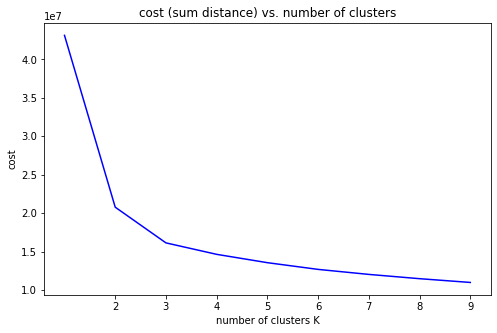

In [44]:
# scree plot: look for elbow
plt.figure(figsize=[8,5])
plt.plot(cost.keys(), cost.values(), color="blue")
plt.title("cost (sum distance) vs. number of clusters")
plt.xticks(np.arange(2,10,1))
plt.xlabel("number of clusters K")
plt.ylabel("cost")

In [45]:
# Confirm visual clue of elbow plot
# KneeLocator class will detect elbows if curve is convex; if concave, will detect knees

cost_knee = KneeLocator(
        x=list(cost.keys()), 
        y=list(cost.values()), 
        S=0.1, curve="convex", direction="decreasing", online=True)

K_cost = cost_knee.elbow   
print("Elbow at k =", f'{K_cost:.0f} clusters')

Elbow at k = 3 clusters


## Training Model

In [46]:
# Fit the cluster
kprototype = KPrototypes(n_clusters = 3, init = 'Cao', n_jobs = 4, verbose = 2, random_state = 0)
kprototype.fit_predict(df_model, categorical = catColumnsPos)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 6


array([2, 2, 2, ..., 0, 0, 0], dtype=uint16)

In [47]:
# Cluster centorid
kprototype.cluster_centroids_

array([[ 3.85912407e+00,  4.03524369e+00,  1.40771031e-02,
         6.84706015e-02,  1.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  7.14109919e-01,
         9.55564257e-01],
       [ 3.63820710e+00,  1.01562409e+01, -5.81860607e-03,
        -1.46173140e-02,  1.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  7.14109919e-01,
         9.55564257e-01],
       [ 3.44691794e+00,  1.67590928e+01, -8.67770623e-03,
        -5.70948466e-02,  1.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  7.14109919e-01,
         9.55564257e-01]])

In [48]:
# Check the iteration of the clusters created
kprototype.n_iter_

3

In [49]:
# Check the cost of the clusters created
kprototype.cost_

16129126.005865917

In [50]:
# Save Model
pickle.dump(kprototype, open('dwi_cluster_kprotoonly.pkl', 'wb'))

In [51]:
# Add the cluster to the copy of dataframe
df_pred = df.copy()
df_pred['cluster'] = kprototype.labels_
df_pred.head()

,id_student,code_module,gender,disability,final_result,score,assessment_type,activity_type,total_activities,sum_click,total_interaction,cluster
0,11391,AAA,M,N,Pass,82.0,TMA,resource,9,16,3555,2
1,11391,AAA,M,N,Pass,82.0,TMA,resource,9,44,3555,2
2,11391,AAA,M,N,Pass,82.0,TMA,resource,9,1,3555,2
3,11391,AAA,M,N,Pass,82.0,TMA,resource,9,2,3555,2
4,11391,AAA,M,N,Pass,82.0,TMA,resource,9,7,3555,2


# Visualize Cluster Result

In [55]:
# Display data based on the cluster  
for i in range (0,3):
    print('\nLearning Style Cluster: {}\n'.format(i))
    print(df_pred[df_pred['cluster']== i].head(10))


Learning Style Cluster: 0

    id_student code_module gender disability final_result  score  \
72       11391         AAA      M          N         Pass   82.0   
73       11391         AAA      M          N         Pass   82.0   
74       11391         AAA      M          N         Pass   82.0   
75       11391         AAA      M          N         Pass   82.0   
76       11391         AAA      M          N         Pass   82.0   
77       11391         AAA      M          N         Pass   82.0   
78       11391         AAA      M          N         Pass   82.0   
79       11391         AAA      M          N         Pass   82.0   
80       11391         AAA      M          N         Pass   82.0   
81       11391         AAA      M          N         Pass   82.0   

   assessment_type activity_type  total_activities  sum_click  \
72             TMA      homepage                 9         16   
73             TMA      homepage                 9         44   
74             TMA      home

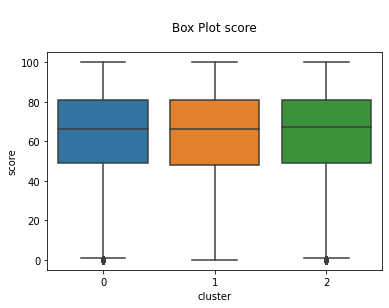

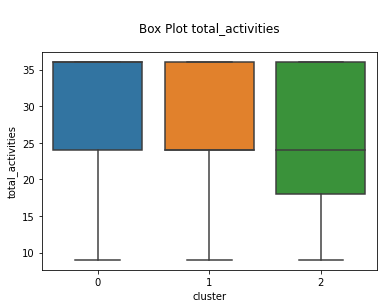

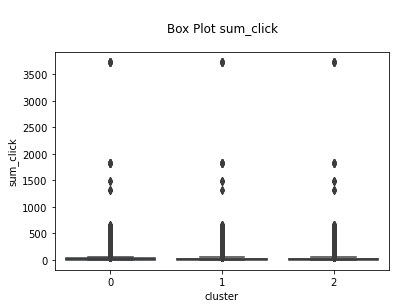

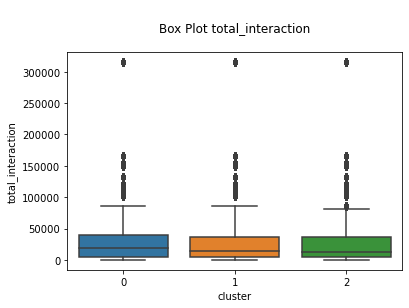

In [56]:
# Data Numerical
kolom_numerik = ['score','total_activities', 'sum_click', 'total_interaction']

for i in kolom_numerik:
    plt.figure(figsize=(6,4))
    ax = sns.boxplot(x = 'cluster', y = i, data = df_pred)
    plt.title('\nBox Plot {}\n'.format(i), fontsize=12)
    plt.show()

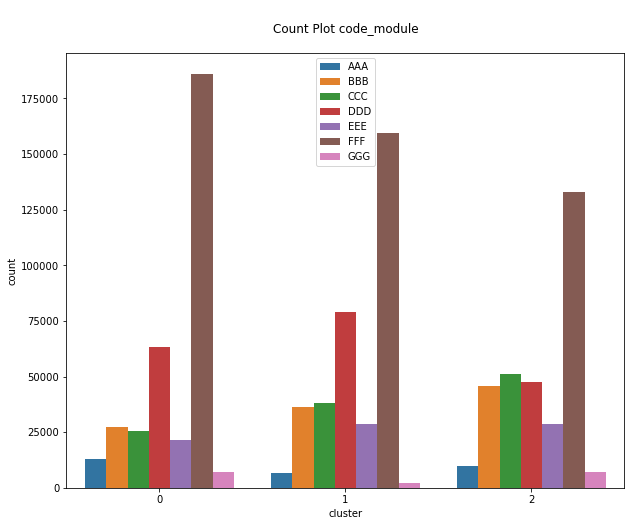

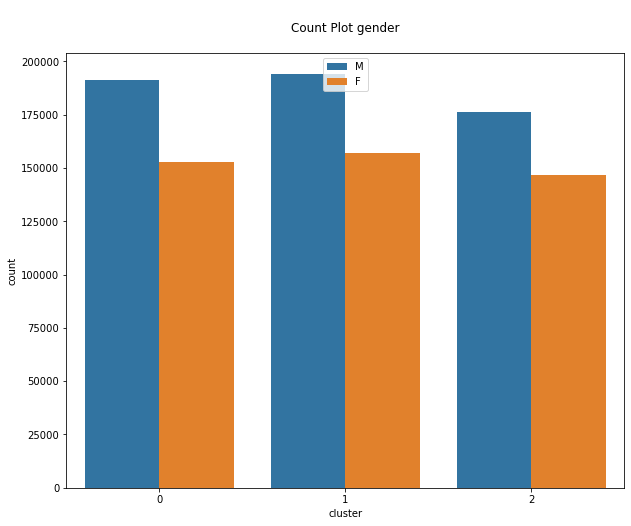

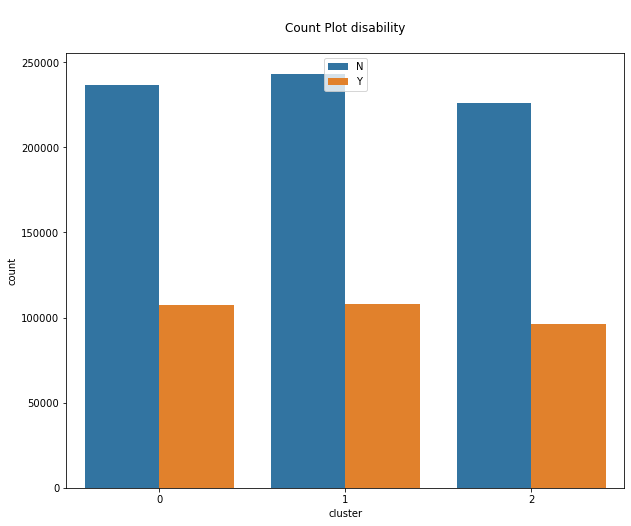

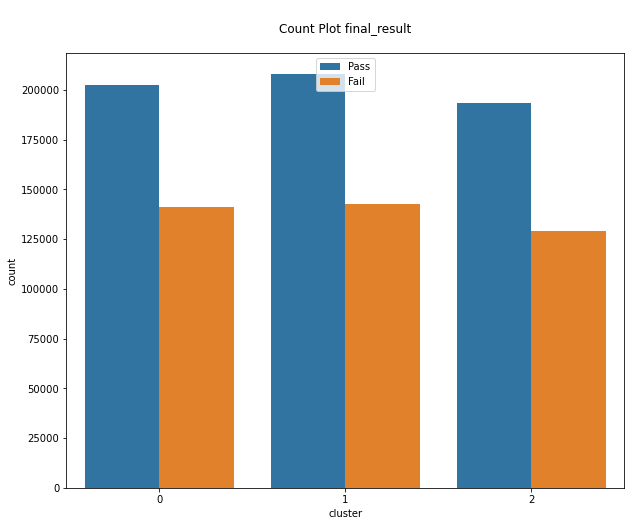

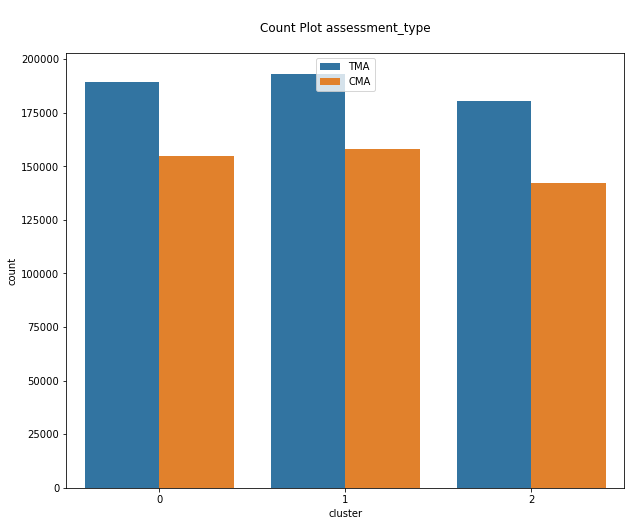

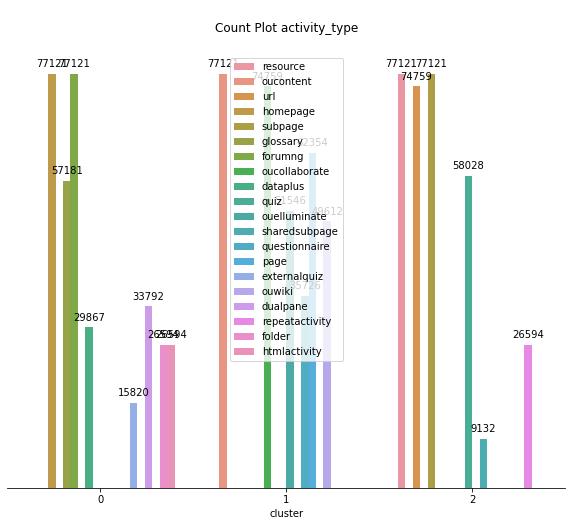

In [57]:
# Data Categorical
kolom_categorical = ['code_module', 'gender', 'disability', 'final_result', 'assessment_type', 'activity_type']

for i in kolom_categorical:
    plt.figure(figsize=(10,8))
    ax = sns.countplot(data = df_pred, x = 'cluster', hue = i )
    plt.title('\nCount Plot {}\n'.format(i), fontsize=12)
    ax.legend(loc="upper center")
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center',
    va = 'center',
    xytext = (0, 10),
    textcoords = 'offset points')
    
sns.despine(right = True, top = True, left = True)
ax.axes.yaxis.set_visible(False)
plt.show()    

In [58]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017963 entries, 0 to 1017962
Data columns (total 12 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   id_student         1017963 non-null  int64  
 1   code_module        1017963 non-null  object 
 2   gender             1017963 non-null  object 
 3   disability         1017963 non-null  object 
 4   final_result       1017963 non-null  object 
 5   score              1017963 non-null  float64
 6   assessment_type    1017963 non-null  object 
 7   activity_type      1017963 non-null  object 
 8   total_activities   1017963 non-null  int64  
 9   sum_click          1017963 non-null  int64  
 10  total_interaction  1017963 non-null  int64  
 11  cluster            1017963 non-null  uint16 
dtypes: float64(1), int64(4), object(6), uint16(1)
memory usage: 87.4+ MB


In [81]:
# helper function: pie charts for categorical variables
def cluster_pies(df_pred):
    
    # number of categorical variables
    c = len(df_pred.select_dtypes("object").nunique())
    
    # number of clusters
    K = df_pred["cluster"].nunique()

    for k in tqdm(range(K)):
        dfc = df_pred[df_pred["cluster"]==k]
        sc = dfc["score"].median()
        ta = dfc["total_activities"].median()
        sc = dfc["sum_click"].median()
        ten = dfc["total_interaction"].median()
        cases = dfc.shape[0]

        fig = plt.figure(figsize=(50, 12))
        fig.suptitle("cluster " + str(k) + ": " + \
            f'{cases:,.0f}' + " cases | " + \
            "median score " + f'{sc:.0f}' + \
            " | median total_activities " + f'{ta:.0f}') + \
            " | median sum_click " + 


        ax1 = plt.subplot2grid((2,c),(0,0))
        plt.pie(dfc["code_module"].value_counts(), labels=dfc["code_module"].unique())
        plt.title("Code Module");

        ax1 = plt.subplot2grid((2,c),(0,1))
        plt.pie(dfc["gender"].value_counts(), labels=dfc["gender"].unique())
        plt.title("Gender");

        ax1 = plt.subplot2grid((2,c),(0,2))
        plt.pie(dfc["disability"].value_counts(), labels=dfc["disability"].unique())
        plt.title("Disability");

        ax1 = plt.subplot2grid((2,c),(0,3))
        plt.pie(dfc["assessment_type"].value_counts(), labels=dfc["assessment_type"].unique())
        plt.title("Assessment Type");

        ax1 = plt.subplot2grid((2,c),(0,4))
        plt.pie(dfc["final_result"].value_counts(), labels=dfc["final_result"].unique())
        plt.title("Final Result");

        ax1 = plt.subplot2grid((2,c),(0,5))
        plt.pie(dfc["activity_type"].value_counts(), labels=dfc["activity_type"].unique())
        plt.title("Activity Type");

        ax1 = plt.subplot2grid((2,c),(0,6))
        plt.pie(dfc["cluster"].value_counts(), labels=dfc["cluster"].unique())
        plt.title("Cluster");


# helper function: medians and modes for each cluster
def cluster_profile(df_pred):
    dfc = df_pred.groupby("cluster").agg({ 
        "score": "median",
        "total_activities": "median",
        "sum_click": "median",
        "total_interaction": "median",
        "code_module": lambda x: x.value_counts().index[0],
        "gender": lambda x: x.value_counts().index[0],
        "disability": lambda x: x.value_counts().index[0],
        "assessment_type": lambda x: x.value_counts().index[0],
        "final_result": lambda x: x.value_counts().index[0],
#         "cluster": lambda x: x.value_counts().index[0],
    })

    cluster_pies(df_pred)
    return dfc

In [82]:
cluster_profile(df_pred).T

  0%|          | 0/3 [00:00<?, ?it/s]

NameError: name 'chrg' is not defined

<Figure size 3600x864 with 0 Axes>

# Correlation Analysis using Dython

In [67]:
# Identify Categorical Variable
categorical_features = identify_nominal_columns(df_pred)
categorical_features

['code_module',
 'gender',
 'disability',
 'final_result',
 'assessment_type',
 'activity_type']

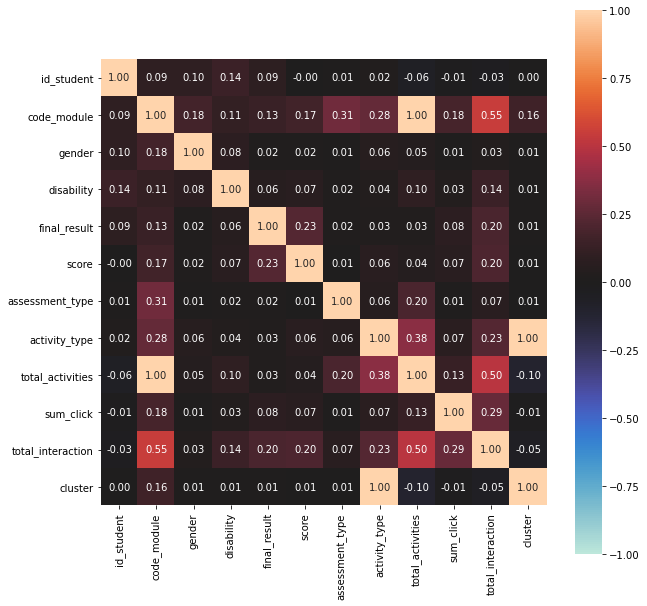

In [68]:
# Generate Correlation Matrix and Heat-Map
complete_correlation = associations(df_pred, filename= 'complete_correlation.png', figsize=(10,10))

In [69]:
# Correlation Matrix Of Complete Dataset
df_complete_corr = complete_correlation['corr']
df_complete_corr.dropna(axis=1, how='all').dropna(axis=0, how='all').style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

,id_student,code_module,gender,disability,final_result,score,assessment_type,activity_type,total_activities,sum_click,total_interaction,cluster
id_student,1.00,0.09,0.10,0.14,0.09,-0.00,0.01,0.02,-0.06,-0.01,-0.03,0.00
code_module,0.09,1.00,0.18,0.11,0.13,0.17,0.31,0.28,1.00,0.18,0.55,0.16
gender,0.10,0.18,1.00,0.08,0.02,0.02,0.01,0.06,0.05,0.01,0.03,0.01
disability,0.14,0.11,0.08,1.00,0.06,0.07,0.02,0.04,0.10,0.03,0.14,0.01
final_result,0.09,0.13,0.02,0.06,1.00,0.23,0.02,0.03,0.03,0.08,0.20,0.01
score,-0.00,0.17,0.02,0.07,0.23,1.00,0.01,0.06,0.04,0.07,0.20,0.01
assessment_type,0.01,0.31,0.01,0.02,0.02,0.01,1.00,0.06,0.20,0.01,0.07,0.01
activity_type,0.02,0.28,0.06,0.04,0.03,0.06,0.06,1.00,0.38,0.07,0.23,1.00
total_activities,-0.06,1.00,0.05,0.10,0.03,0.04,0.20,0.38,1.00,0.13,0.50,-0.10
sum_click,-0.01,0.18,0.01,0.03,0.08,0.07,0.01,0.07,0.13,1.00,0.29,-0.01


In [70]:
# Correlation Matrix of Categorical Variables Only
selected_column = df_pred[categorical_features]
categorical_df = selected_column.copy()

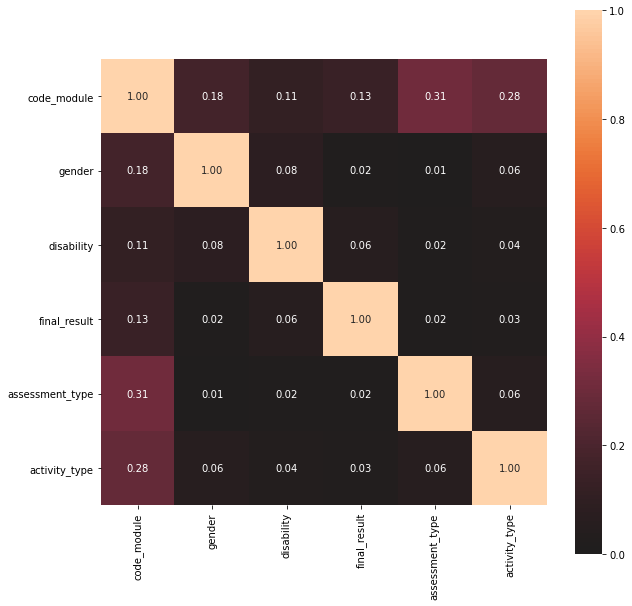

In [71]:
categorical_correlation= associations(categorical_df, filename= 'categorical_correlation.png', figsize=(10,10))

In [72]:
df_pred.to_csv('D:\dwi\pca\dataset\df_pred.csv')

In [74]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017963 entries, 0 to 1017962
Data columns (total 12 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   id_student         1017963 non-null  int64  
 1   code_module        1017963 non-null  object 
 2   gender             1017963 non-null  object 
 3   disability         1017963 non-null  object 
 4   final_result       1017963 non-null  object 
 5   score              1017963 non-null  float64
 6   assessment_type    1017963 non-null  object 
 7   activity_type      1017963 non-null  object 
 8   total_activities   1017963 non-null  int64  
 9   sum_click          1017963 non-null  int64  
 10  total_interaction  1017963 non-null  int64  
 11  cluster            1017963 non-null  uint16 
dtypes: float64(1), int64(4), object(6), uint16(1)
memory usage: 87.4+ MB
